In [1]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata
%matplotlib inline

In [4]:
!pip show jax 
!pip show jaxlib

Name: jax
Version: 0.4.8
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: ml-dtypes, numpy, opt-einsum, scipy
Required-by: chex, dopamine-rl, flax, optax, orbax, tensorflow
Name: jaxlib
Version: 0.4.7+cuda11.cudnn82
Summary: XLA library for JAX
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: ml-dtypes, numpy, scipy
Required-by: chex, dopamine-rl, optax, orbax


In [ ]:
!pip uninstall -y jax jaxlib
!pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# **Physics-informed DeepONets**

We consider parametric PDEs of the form: 
$${\cal N}(u,s)=0$$
where, $u$ is the input function, and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:
$$G(u):= s$$

Similar to a PINN, a Physics-informed DeepONets output functions consistent with physical constraints by minimizing the residual of an underlying governing law (i.e., linear differential operator).

$$\mathcal{L}_{Residual}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|\mathcal{N}\left({\bf u}_{i}(x),\tilde{G}({\bf u}_{i})(y_{j})\right)\right|^2$$

where $\mathcal{N}$ is a linear differential operator, and $\{y_j\}_{i=1}^{Q}$ are the collocation points.

So the total loss would be:

$$\mathcal{L}(\theta)=\mathcal{L}_{Operator}(\theta)+\mathcal{L}_{Residual}(\theta)$$







# **Problem Setup**



**Burgers' Equation**

$$\frac{\partial s}{\partial t}+s\frac{\partial s}{\partial x}=\kappa\frac{\partial^2 s}{\partial x^2}, \quad (x,t)\in [{\rm -\rho\cdot\pi,\rho\cdot\pi}]\times[0,{\rm T}], \quad \kappa>0$$

$$s(x-\pi,t) = s(x+\pi,t), \quad s(x,0)=u_0(x)$$

where, $\kappa$ denotes the fluid viscosity, $\ u_0(x)$ is $2\pi$-periodic with zero mean i.e. $\int_{-\pi}^{\pi}u_0(t)dt=0$ and $\rho,{\rm T}\in{\mathbb N}$.

**Note:** We will not use any paired input-output training data for our model. We only know the PDE, initial condition and that the boundary condition is periodic.

**Residual Loss**

Our $\tilde{{\cal G}}$ will map the initial condition $u_0(x)$ to the solution to Burgers' equation $s(x,t)$. Hence, we will approximate the implicit solution operator $({\cal G})$ with a PI-DeepONet ($\tilde{{\cal G}}$).

Rearranging Burgers' Equation, we get

$$\frac{\partial s_{i}}{\partial t}-s_i\frac{\partial s_{i}}{\partial x}-\kappa\frac{\partial^2 s_i}{\partial x^2}=0$$

So since ideally $\tilde{{\cal G}}({\bf u}_{i})(x,t)\approx {\cal G}(u_{i})(x,t):= s_{i}(x,t)$,

$$\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial t}-\tilde{{\cal G}}({\bf u}_{i})(x,t)\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x}-\kappa\frac{\partial^2 \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x^2}\approx 0$$

Lets call:
$$\tilde{R}_{i}(x,t)=\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial t}-\tilde{{\cal G}}({\bf u}_{i})(x,t)\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x}-\kappa\frac{\partial^2 \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x^2}$$

So our $\mathcal{L}_{Residual}$ will be
$$\mathcal{L}_{Residual}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{R}_{i}(x_{j},t_{j})\right|^2,$$

where $(x_{j},t_{j})$ are the *collocation points* (i.e. points in our domain where we evaluate the PDE). 


**Operator Losses**

Since we are working with periodic boundary conditions, we require $\tilde{{\cal G}}({\bf u}_{i})(x_{j}-\pi,t_{j})=\tilde{{\cal G}}({\bf u}_{i})(x_{j}+\pi,t_{j})$ and

$$\mathcal{L}_{Operator1}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{{\cal G}}({\bf u}_{i})(x_{j}-\pi,t_{j}) - \tilde{{\cal G}}({\bf u}_{i})(x_{j}+\pi,t_{j})\right|^2,$$

where $x_{j},t_j$ are uniformly sampled points from our domain.

Lastly, we will enforce our initial condition with the loss function

$$\mathcal{L}_{Operator2}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{\cal G}({\bf u}_{i})(x_{j},0) - {\bf u}_{i}(x_j)\right|^2,$$

where $x_{j}$ are uniformly sampled points between $[{\rm -n\pi,n\pi}]$. 

Finally, the total loss will be 
$$\mathcal{L}(\theta)=\mathcal{L}_{Residual}(\theta)+\lambda_2\mathcal{L}_{operator1}(\theta)+\lambda_1\mathcal{L}_{operator2}(\theta) , \ \lambda_1,\lambda_2>0$$

**Training data**

$u_{\rm train}\in{\mathbb R}^{N_{\rm train} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_i(x)=[{\rm u}_i(x_1), {\rm u}_i(x_2), \dots, {\rm u}_i(x_{\rm m})] \ \forall i \in N_{\rm train} \right)$.

$y_{\rm train}= $ Uniformly sampled collocation points $\left(i.e. \ (x_j,t_j)\sim{\cal U}\left(\left([{\rm -\rho\pi,\rho\pi}]\times(0,T)\right)^{P_{\rm train}}\right)\right)$

$s_{\rm train}= $ Residual labels/measurements, since the PDE is without forcing this becomes a matrix of zeros. 

Hence, for ${\cal L}_{Residual}(\theta)$ we have, 

$$\underset{Residual \ \rm Training \ Data}{\underbrace {u_{\rm train}, \ y_{\rm train_0}\in{\mathbb R}^{P_{\rm train} \ \times \ 2}, \ s_{\rm train_0}\in{\mathbb R}^{P_{train}}}}$$

$y_{\rm train_1}= $ Uniformly sampled points from our domain $\left(i.e. \ (x_j-\pi, t_j)\sim{\cal U}\left(\left([{\rm -\rho\pi,\rho\pi}]\times(0,T)\right)^{P_{\rm train}}\right)\right)$

$s_{\rm train_1}= $ Uniformly sampled from our domain $\left(i.e. \ (x_j+\pi, t_j)\sim{\cal U}\left(\left([{\rm -\rho\pi,\rho\pi}]\times(0,T)\right)^{P_{\rm train}}\right)\right)$

For ${\cal L}_{Operator_1}(\theta)$ we have,

$$\underset{Operator1 \ \rm Training \ Data}{\underbrace {u_{\rm train}, \ y_{{\rm train_1}}\in{\mathbb R}^{P_{\rm train} \ \times \ 2}, \ s_{{\rm train_1}}\in{\mathbb R}^{P_{\rm train} \ \times \ 2}}}$$


$y_{\rm train_2}= $ Uniformly sampled points from our initial condition $\left(i.e. \ s_i(x_j,0) \text{ for } \ x_j\sim{\cal U}\left([{\rm -\rho\pi,\rho\pi}]^{P_{\rm train}}\right)\right)$

$s_{\rm train_2}= $ The value of initial condition at $x_j$ $\left(i.e. \ {\bf u}_i(x_j)\right)$ 

For ${\cal L}_{Operator_2}(\theta)$ we have,

$$\underset{Operator2 \ \rm Training \ Data}{\underbrace {u_{\rm train}, \ y_{\rm train_2}\in{\mathbb R}^{P_{\rm train} \ \times \ 2}, \ s_{\rm train_2}\in{\mathbb R}^{P_{train}}}}$$ 

**Note:** our $\ P_{train}\ $ points are uniformly resampled for each loss $ \ \ \blacksquare$

**Test Data**

$$\mathcal{L}_{Test}(\theta)= \frac{1}{N_{\rm test}P_{\rm test}}\sum_{i=1}^{N_{\rm test}}\sum_{j=1}^{P_{\rm test}}\left|s_i(x_j,t_j) -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(x_j,t_j)\right|^2$$

$u_{\rm test}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_i(x)=[{\rm u}_i(x_1), {\rm u}_i(x_2), \dots, {\rm u}_i(x_{\rm m})] \ \forall i \in N_{\rm test} \right)$

$y_{\rm test}= $ Uniformly sampled collocation points from our domain $\left(i.e. \ (x_j,t_j)\sim{\cal U}\left(([{\rm -n\pi,n\pi}]\times(0,T))^{P_{\rm test}}\right)\right)$

$s_{\rm test}= $ Numerical solution of PDE at respective collocation points $\left(i.e. \ s(x_j,t_j)\right)$ 

$$\underset{\rm Test \ Data}{\underbrace {u_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ {\rm m}}, \ y_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test}}, \ s_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{test}}}} \ \ \ \ \blacksquare$$ 



# **Auxiliary Functions**

In [2]:
def generate_initial_condition(N, A, key):
    """Generate an initial condition that is 2π-periodic and has zero mean in the interval [-π, π].
    
    Args:
        N (int): Number of sine terms to include in the Fourier series.
        A (float): Amplitude of the sine terms.
        key (jax.random.PRNGKey): A random number generator key.
        
    Returns:
        callable: A function representing the initial condition.
    """
    # Generate random coefficients for the sine terms
    coefficients = A * random.normal(key, (N,))

    def initial_condition(x):
        sine_terms = np.zeros_like(x)
        for n in range(N):
            sine_terms += coefficients[n] * np.sin((n + 1) * x)
        
        # Set small values to zero
        threshold = 1e-14
        sine_terms = np.where(np.abs(sine_terms) < threshold, 0, sine_terms)
        
        return sine_terms

    return initial_condition

In [3]:
# A numerical solver for Burgers' equation
def solve_burgers(key, Nx, Nt, P, T_lim, period, kappa):
  """Solve the 1D Burgers' equation u_t + uu_x = k * u_xx with a given initial condition derived from 
  the Fourier Series sine represntation and zero boundary conditions. Also generate input and output
  sensor locations and measurements."""
  xmin, xmax = -period*np.pi, period*np.pi
  tmin, tmax = 0, T_lim

  # Generate subkeys
  subkeys = random.split(key, 2)

  # Generate the initial condition function
  N = 10  # Number of sine terms in the Fourier series
  A = 0.02  # Amplitude of the sine terms
  initial_condition_fn = generate_initial_condition(N, A, subkeys[0])

  # Create grid
  x = np.linspace(xmin, xmax, Nx)
  t = np.linspace(tmin, tmax, Nt)
  h = x[1] - x[0]
  dt = t[1] - t[0]
  h2 = h ** 2

  # Compute initial condition
  u0 = initial_condition_fn(x)

  D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1) # first derivative approximation matrix
  D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
  D3 = np.eye(Nx - 2) # enforce BCs
  M = -np.diag(D1 @ (kappa * np.ones_like(x))) @ D1 - 4 * np.diag(kappa * np.ones_like(x)) @ D2
  m_bond = 8 * h ** 2 / dt * D3 + M[1:-1, 1:-1]
  c = 8 * h ** 2 / dt * D3 - M[1:-1, 1:-1]

  u = np.zeros((Nx, Nt))
  u = u.at[:, 0].set(u0)

  def body_fn(i, u):
      u_x = D1 @ u[:, i]
      nonlinear_term = u[1:-1, i] * u_x[1:-1]
      b2 = c @ u[1:-1, i].T - nonlinear_term * h ** 2 / 2
      u = u.at[1:-1, i + 1].set(np.linalg.solve(m_bond, b2))
      return u

  UU = lax.fori_loop(0, Nt - 1, body_fn, u)

  # Input sensor locations and measurements
  xx = np.linspace(xmin, xmax, m)
  u = initial_condition_fn(xx)

  # Output sensor locations and measurements
  idx = random.randint(subkeys[1], (P, 2), 0, max(Nx, Nt))
  y = np.concatenate([x[idx[:, 0]][:, None], t[idx[:, 1]][:, None]], axis=1)  # randomly generated collocation points
  s = UU[idx[:, 0], idx[:, 1]]

  # # Plot function used for initial condition
  # plt.figure()
  # plt.plot(x, u0, color=plt.cm.viridis(0.1))
  # plt.title("Fourier-Sampled Initial Condition")
  # plt.xlabel("x")
  # plt.ylabel("$u_0(x)$")
  # plt.show()

  return (x, t, UU), (u, u0, y, s)

In [4]:
# 3D plot function
def plot_3d(ax, X, T, f):
    surf = ax.plot_surface(X, T, f, cmap='viridis')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$s(x,t)$')

In [5]:
# Color plot function
def plot(ax, X, T, f):
    pcm = ax.pcolor(X, T, f, cmap='viridis')
    plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')

In [6]:
# Error plot function
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='#440154'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

# **Data Generation**

In [41]:
# Define hyperparamaters and grid 
kappa = 0.01 # fluid viscosity 
period = 1 # x-domain period (rho)
T_lim = 10 # t-domain limit

# Resolution of the solution (Grid of 100x100)
Nx = 100
Nt = 100
x = np.linspace(-period*np.pi, period*np.pi, Nx)
t = np.linspace(0, T_lim, Nt)

# Select the number of sensors
m = 100   # number of input sensors
P_train = 100 # number of evaluation points for each input 

### Example of generating training data for a single input $(N_{\rm train}=1)$

#### Demonstration of using solve_heat() to Generate a Solution to the Heat Equation and Training Data

We will randomly sample a function $u$ from a zero-mean Gaussian process with an exponential quadratic kernel with a length scale: $l=0.60$.



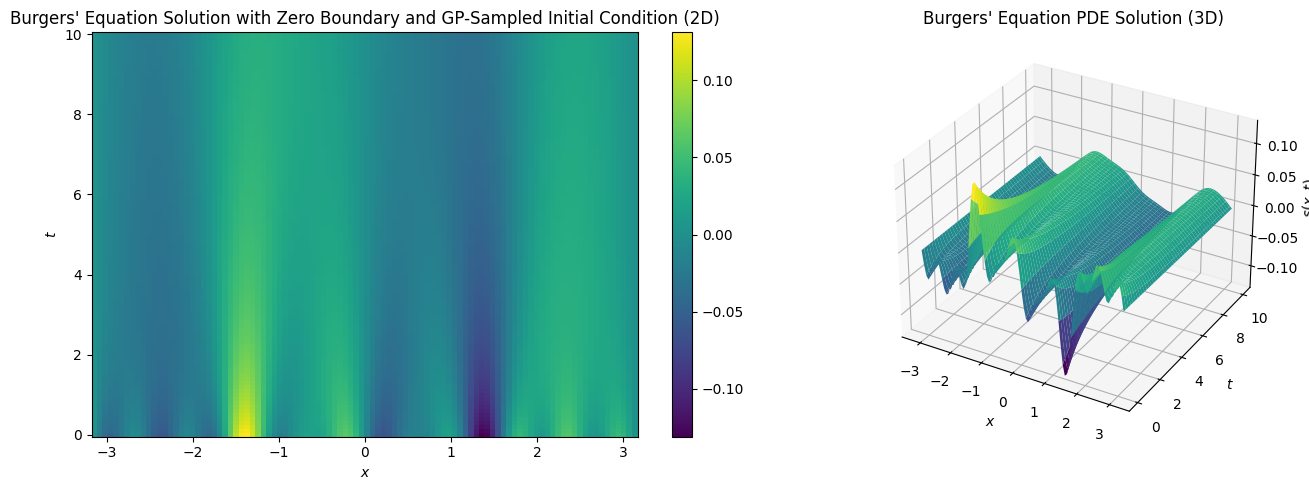

In [42]:
config.update("jax_enable_x64", True)
# Numerical solution
key = random.PRNGKey(0)
(x, t, UU), (u, u0, y, s) = solve_burgers(key, Nx , Nt, P_train,  T_lim, period, kappa)

XX, TT = np.meshgrid(x,t)

# Create a new figure with two subplots side by side, with the first being a 3D plot
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(122, projection='3d')
plot_3d(ax1, XX, TT, UU.T)
ax1.set_title('Burgers\' Equation PDE Solution (3D)')

ax2 = fig.add_subplot(121)
plot(ax2, XX, TT, UU.T)
ax2.set_title('Burgers\' Equation Solution with Zero Boundary and GP-Sampled Initial Condition (2D)')

plt.tight_layout()
plt.show()

#### Enforcing PDE Residual 

Select $P_{\rm train}$ evaluation points inside our domain → $\textbf{y}=y_{1},y_{2},...,y_{P_{\rm train}}$

Compute the error related to the underlying governing laws (i.e., PDE)→$\mathcal{L}_{Residual}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{R}_{i}(x_{j},t_{j})\right|^2,$

$$\tilde{R}_{i}(x_j,t_j)=\frac{\partial \tilde{G}({\bf u}_{i})(x_j,t_j)}{\partial t}-k\frac{\partial^2 \tilde{G}({\bf u}_{i})(x_j,t_j)}{\partial x^2} $$

Resulting matrix will look like: $\underset{m-evaluations \ of \ u \ repeated \ P_{\rm train} \ times \ along \ the \ row \ axis}{\underbrace {\left[[u(x_1), \dots, u(x_m)], \dots, [u(x_1), \dots, u(x_m)]\right]}}$

In [ ]:
# Sample points from our domain
# Generate subkeys 
subkeys = random.split(key, 4)
# Sample collocation points
x_1_idx = random.choice(subkeys[0], np.arange(Nx), shape = (P_train,1),replace=False)
x_1 = x[x_1_idx]
t_1 = random.uniform(subkeys[1], minval = 0, maxval = T, shape = (P_train,1))
# Training data for Residual
u_train = np.tile(u, (P_train,1)) # Add dimentions-> copy u P_train times
y_train = np.hstack([x_1, t_1]) # stack the coordinates (x,t)
s_train = np.zeros((P_train, 1)) # zero forcing

print("u_train dimensions:", u_train.shape)
print("y_train dimensions:", y_train.shape)
print("s_train dimensions:", s_train.shape)

u_train dimensions: (100, 100)
y_train dimensions: (100, 2)
s_train dimensions: (100, 1)


#### Enforcing Periodic BCs 

Using same evaluation points $(\textbf{y}=y_{1},y_{2},...,y_{P_{\rm train}}),$

Ideally $\tilde{{\cal G}}({\bf u}_{i})(x_{j}-\pi,t_{j})=\tilde{{\cal G}}({\bf u}_{i})(x_{j}+\pi,t_{j})$, so compute the error → $\mathcal{L}_{Operator1}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{{\cal G}}({\bf u}_{i})(x_{j}-\pi,t_{j}) - \tilde{{\cal G}}({\bf u}_{i})(x_{j}+\pi,t_{j})\right|^2.$

In [ ]:
# Prepare x values with a shift of +π and -π
x_1_minus_pi = x_1 - np.pi
x_1_plus_pi = x_1 + np.pi

# Training data for BC
u_train = np.tile(u, (P_train, 1))  # Add dimensions-> copy u P_train times
y_train_minus_pi = np.hstack([x_1_minus_pi, t_1])  # stack the coordinates (x-π,t)
# y_train_plus_pi = np.hstack([x_1_plus_pi, t_1])  # stack the coordinates (x+π,t)
y_train_plus_pi = x_1_plus_pi  # solution measurements in this case are x+π values

print("y_train_minus_pi dimensions:", y_train_minus_pi.shape)
print("y_train_plus_pi dimensions:", y_train_plus_pi.shape)

y_train_minus_pi dimensions: (100, 2)
y_train_plus_pi dimensions: (100, 1)


#### Enforcing IC

Select $P_{\rm train2}$ evaluation points $(x_j,0)$ along the initial condition → $\textbf{y}=y_{1},y_{2},...,y_{P_{\rm train2}}$

Ideally $\tilde{\cal G}({\bf u}_{i})(x_{j},0) = \exp\left(-\frac{1}{2\kappa}∫^{x_j}_{-\pi}u_i(t)dt\right)$, so compute the error → $\mathcal{L}_{Operator2}(\theta)=\frac{1}{N_{\rm train}P_{\rm train2}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train2}}\left|\tilde{\cal G}({\bf u}_{i})(x_{j},0) - \exp\left(-\frac{1}{2\kappa}∫^{x_j}_{-\pi}u_i(z)dz\right)\right|^2,$

In [ ]:
# Sample IC evaluation points 
x_2_idx = random.choice(subkeys[2], np.arange(Nx), shape = (P_train2,1),replace=False)
x_2 = x[x_2_idx] 
t_2 = np.zeros((P_train2, 1))

# Training data for IC
u_train2 = np.tile(u, (P_train2,1)) # add dimentions-> copy u P_train2 times along row 
y_train2 = np.hstack((x_2, t_2))

x_2 = x_2.squeeze()

# Compute the initial condition and store in s_train2
s_train2 = np.zeros((P_train2, 1))

# Compute the initial condition and store in s_train2
integrals = np.array([compute_integral(f_fn, x_j) for x_j in x_2])

exponential_terms = np.exp(-0.5 * (1 / kappa) * integrals)
s_train2 = exponential_terms[:, None]

#OLD BELOW THAST DOES INTEGRAL
# integrals = compute_integral(f_fn, x_2)

# exponential_terms = np.exp(-0.5 * (1 / kappa) * integrals)
# s_train2 = exponential_terms[:, None]

print("u_train2 dimensions:", u_train2.shape)
print("y_train2 dimensions:", y_train2.shape)
print("s_train2 dimensions:", s_train2.shape)
print(integrals)

NameError: ignored

## **Generate DeepONet Data**

In [43]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, t, UU), (u, u0, y, s) = solve_burgers(key, Nx , Nt, P,  T_lim, period, kappa)

    # Generate subkeys
    subkeys = random.split(key, 4)

    # Sampled input data
    u_train = np.tile(u, (P,1)) # add dimensions-> copy u P times

    # Sample collocation points
    x_1_idx = random.choice(subkeys[0], np.arange(Nx), shape = (P,1))
    x_1 = x[x_1_idx]
    t_1 = random.uniform(subkeys[1], minval = 0, maxval = T_lim, shape = (P,1)) 
    # Training data for Residual
    y_train = np.hstack([x_1, t_1]) # stack the coordinates (x,t)
    s_train = np.zeros((P, 1)) # zero forcing 

    # Prepare BC values with a shift of -π and π
    x_1_minus_pi = x_1 - np.pi
    x_1_plus_pi = x_1 + np.pi
    # Training data for BC
    y_train1 = np.hstack([x_1_minus_pi, t_1])
    s_train1 = np.hstack([x_1_plus_pi, t_1])  

    # Sample IC evaluation points 
    x_2_idx = random.choice(subkeys[2], np.arange(Nx), shape = (P,1))
    x_2 = x[x_2_idx] 
    t_2 = np.zeros((P, 1))
    u0_at_x_2 = u0[x_2_idx] # input evaluated at x_j points
    # Training data for IC
    y_train2 = np.hstack((x_2, t_2))
    s_train2 = u0_at_x_2

    return u_train, y_train, s_train, y_train1, s_train1, y_train2, s_train2

In [44]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, u0, y, s) = solve_burgers(key, Nx , Nt, P,  T_lim, period, kappa)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

In [45]:
N_train = 3000 # number of input samples

# Select N keys to create N Functions
key = random.PRNGKey(0)
keys = random.split(key, N_train)

config.update("jax_enable_x64", True)
u_train, y_train, s_train, y_train1, s_train1, y_train2, s_train2 = vmap(generate_one_training_data, (0, None))(keys, P_train)

# Reshape the data into dimensions (N_train*P_train, m) -> each input sample repeated down column P_train times
'''Residual data'''
u_res_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_res_train = np.float32(y_train.reshape(N_train * P_train,-1))
s_res_train = np.float32(s_train.reshape(N_train * P_train,-1))

'''Boundary data'''
u_bcs_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_bcs_train = np.float32(y_train1.reshape(N_train * P_train,-1))
s_bcs_train = np.float32(s_train1.reshape(N_train * P_train,-1))

'''Initial data'''
u_ics_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_ics_train = np.float32(y_train2.reshape(N_train * P_train,-1))
s_ics_train = np.float32(s_train2.reshape(N_train * P_train,-1))

In [46]:
# Plot function used for initial condition
# plt.figure()
# plt.plot(x, s_train2.flatten(), color=plt.cm.viridis(0.1))
# plt.title("Fourier-Sampled Initial Condition")
# plt.xlabel("x")
# plt.ylabel("$u_0(x)$")
# plt.show()

In [47]:
N_test = 4 # number of input samples 
key = random.PRNGKey(12345) # it should be different than the key we used for the training data
P_test = 75
Nx = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

config.update("jax_enable_x64", False)

In [48]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input 
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# **DeepONet**

In [49]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [50]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_test_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx = grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)
        res = s_t + s * s_x - kappa  * s_xx
        return res

    # Define Residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss     

    # Define Boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        s = outputs
        # Compute forward pass
        s_pred_minus_pi = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_pred_plus_pi = vmap(self.operator_net, (None, 0, 0, 0))(params, u, s[:,0], s[:,1])
        # Compute loss
        loss = np.mean((s_pred_minus_pi - s_pred_plus_pi)**2)
        return loss

    # Define Initial loss
    def loss_ics(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss 

    # Define Total loss
    def loss(self, params, bcs_batch, res_batch, ics_batch, w_res=2.0, w_bcs=1.0, w_ics=1.0):
        loss_res = self.loss_res(params, res_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_ics = self.loss_ics(params, ics_batch)
        loss = w_res * loss_res + w_bcs * loss_bcs + w_ics * loss_ics
        return loss 

    # Define Test loss
    def loss_test(self, params, u_test, y_test, s_test):
      s_pred = self.predict_s(params, u_test, y_test)
      return np.mean((s_test - s_pred)**2) / np.mean((s_test)**2)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch, ics_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch, ics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, ics_dataset, nIter):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)
        ics_data = iter(ics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)
            ics_batch = next(ics_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch, ics_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                test_loss_value = self.loss_test(params, u_test, y_test, s_test)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_test_log.append(test_loss_value)

                # Print losses
                pbar.set_postfix({'Training Loss': loss_value, 'Residual Loss': loss_res_value, 'Average Test Loss': test_loss_value})

    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

# **Train Model**

In [51]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = PI_DeepONet(branch_layers, trunk_layers)

# Create data set
batch_size = (N_train * 3)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)

In [56]:
# Train
model.train(bcs_dataset, res_dataset, ics_dataset, nIter=40000)

100%|██████████| 40000/40000 [19:19<00:00, 34.49it/s, Training Loss=0.00011993425, Residual Loss=1.9175652e-05, Average Test Loss=1.2919898]


# **Evaluate Model**

### **Visualise Results**

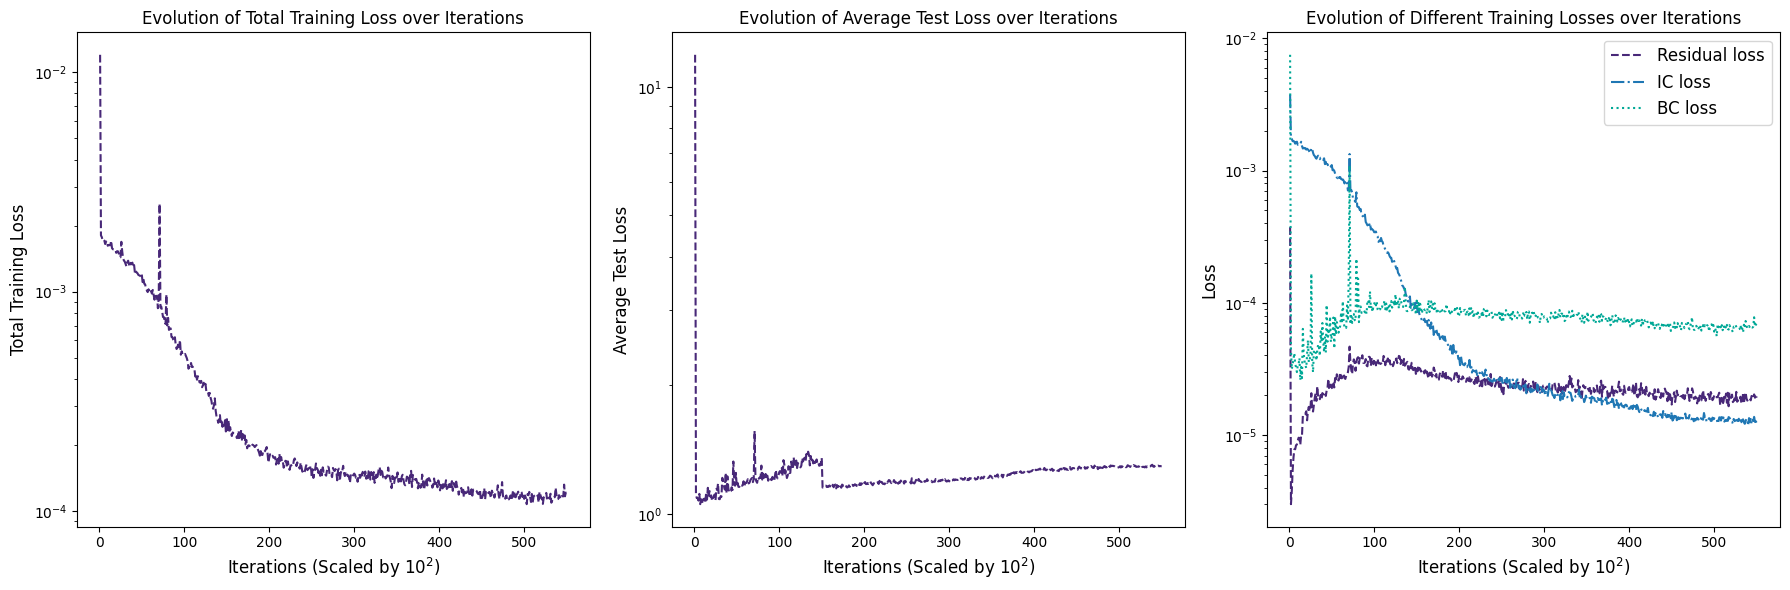

In [57]:
# Visualizations
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Colors from the 'viridis' colormap
medium_purple = '#482878'
light_purple = '#3b528b'
viri_green = '#00A896'

# Combined loss per 100 iteration
combined_loss_eval_numbers = range(1, len(model.loss_log) + 1)
axs[0].plot(combined_loss_eval_numbers, model.loss_log, '--', color=medium_purple, label='Training loss')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[0].set_ylabel('Total Training Loss', fontsize='large')
axs[0].set_title('Evolution of Total Training Loss over Iterations', fontsize='large')

# Average fractional test loss
test_loss_eval_numbers = range(1, len(model.loss_test_log) + 1)
axs[1].plot(test_loss_eval_numbers, model.loss_test_log, '--', color=medium_purple, label='T loss')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[1].set_ylabel('Average Test Loss', fontsize='large')
axs[1].set_title('Evolution of Average Test Loss over Iterations', fontsize='large')

# Losses per 100 iteration (residual, IC, and BC)
res_loss_eval_numbers = range(1, len(model.loss_res_log) + 1)
axs[2].plot(res_loss_eval_numbers, model.loss_res_log, '--', color=medium_purple, label='Residual loss')
ics_loss_eval_numbers = range(1, len(model.loss_ics_log) + 1)
axs[2].plot(ics_loss_eval_numbers, model.loss_ics_log, '-.', label='IC loss')
bcs_loss_eval_numbers = range(1, len(model.loss_bcs_log) + 1)
axs[2].plot(bcs_loss_eval_numbers, model.loss_bcs_log, ':', color=viri_green, label='BC loss')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[2].set_ylabel('Loss', fontsize='large')
axs[2].set_title('Evolution of Different Training Losses over Iterations', fontsize='large')
axs[2].legend(fontsize='large')

plt.tight_layout()
plt.show()

###  **Visualise Predicted Solution of a New Test Function**  

In [58]:
N_test = 1 # number of input samples 
key = random.PRNGKey(333) # different key
P_test = 100
Nx = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(-period*np.pi, period*np.pi, Nx)
t = np.linspace(0, T_lim, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

In [ ]:
print('TEST')
for i in s_test:
  print(i)
print('PRED')
for i in s_pred:
  print(i)

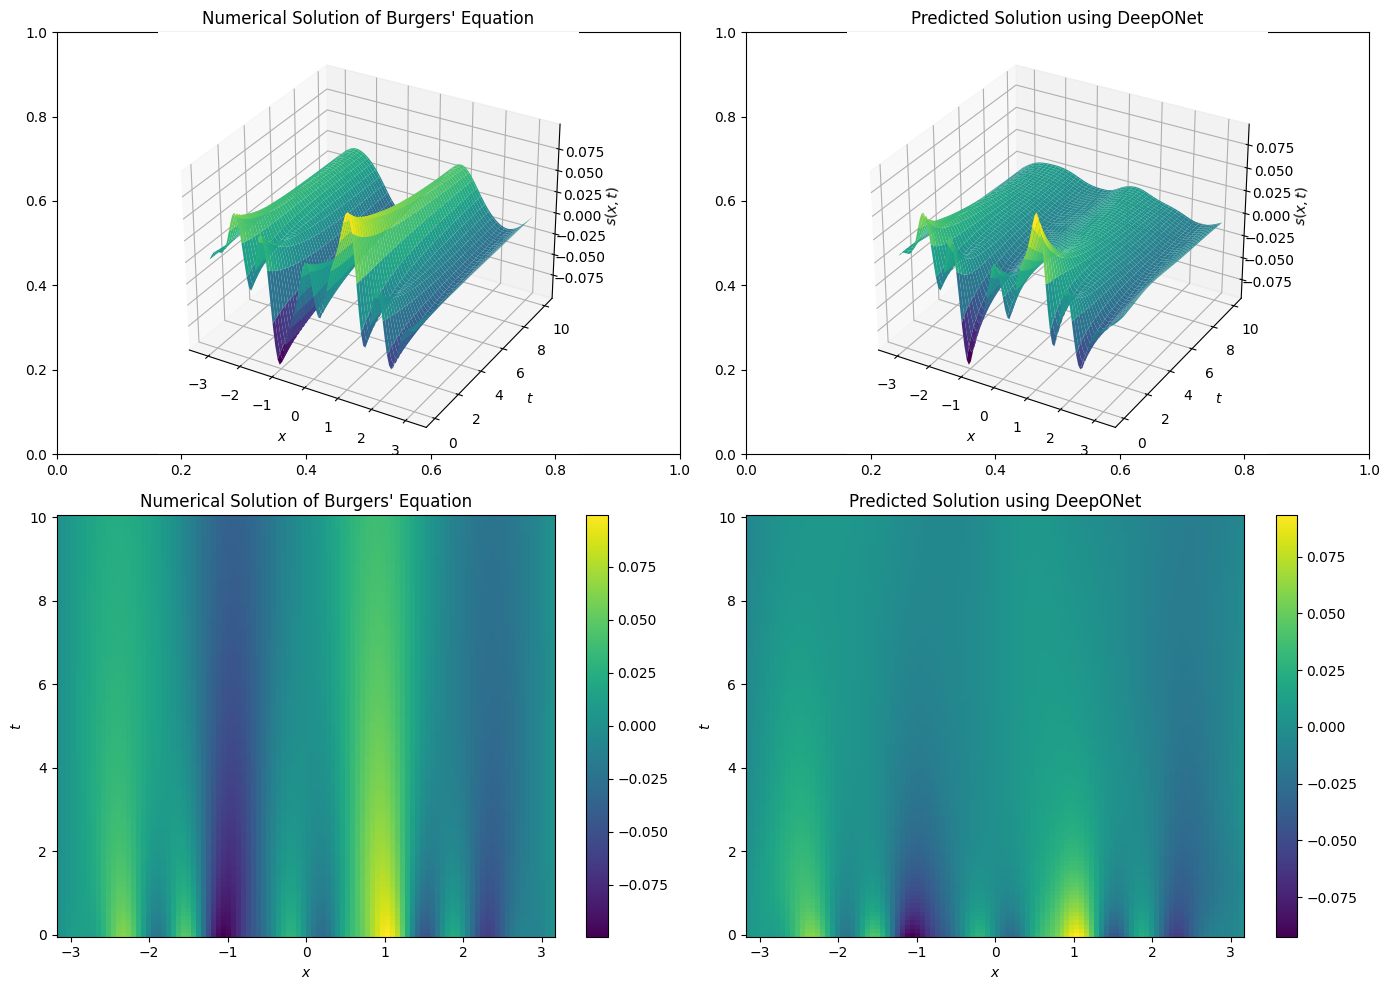

In [59]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top row: 3D plots
# Numerical Solution of Burgers' Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, TT, S_test)
axs[0, 0].set_title("Numerical Solution of Burgers' Equation", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, TT, S_pred)
axs[0, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

# Bottom row: 2D color plots
# Numerical Solution of Burgers' Equation
plot(axs[1, 0], XX, TT, S_test)
axs[1, 0].set_title("Numerical Solution of Burgers' Equation", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, TT, S_pred)
axs[1, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

plt.tight_layout()
plt.show()